# Задача
Исследовать и оценить эффективность использования методов машинного обучения в задачах определения вероятности выплаты страхового возмещения клиенту

Признаки:<br><br>
age - возраст<br>
gender - пол <br>
race - раса<br>
driving experience - стаж вождения<br>
education - образование<br>
income - доход<br>
credit score - кредитный рейтинг<br>
vehicle ownership - наличие автомобиля<br>
vehicle year - год выпуска автомобиля<br>
married - семейное положение<br>
children - кол-ва детей<br>
postal code - почтовый индекс<br>
annual milage - пробег автомобиля<br>
vehicle type - тип автомобиля<br>
speeding violations - превышения скорости<br>
duis - вождение в нетревзвом виде<br>
past accidents - прошлые инциденты<br>
outcome - решение о страховом возмещении

# 1. Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np


from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler

from collections import Counter
from sklearn import datasets, linear_model, metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Загрузка данных и обзор

Начнем с считывания csv-файла Car_Insurance_Data в pandas dataframe.

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Car_Insurance_Claim.csv")

In [4]:
print(f'Набор данных имеет {df.shape[0]} строк и {df.shape[1]} столбцов.') 

Набор данных имеет 10000 строк и 19 столбцов.


In [5]:
df.head()

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [6]:
#Проверка информации о наборе данных, которая описывает нулевые значения, тип данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  object 
 2   GENDER               10000 non-null  object 
 3   RACE                 10000 non-null  object 
 4   DRIVING_EXPERIENCE   10000 non-null  object 
 5   EDUCATION            10000 non-null  object 
 6   INCOME               10000 non-null  object 
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  object 
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  object 
 15  SPEEDING_VIOLATIONS  10000 non-null  

In [7]:
df.describe()

,ID,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
count,10000.000000,9018.000000,10000.000000,10000.000000,10000.000000,10000.000000,9043.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,500521.906800,0.515813,0.697000,0.498200,0.688800,19864.548400,11697.003207,1.482900,0.23920,1.056300,0.313300
std,290030.768758,0.137688,0.459578,0.500022,0.463008,18915.613855,2818.434528,2.241966,0.55499,1.652454,0.463858
min,101.000000,0.053358,0.000000,0.000000,0.000000,10238.000000,2000.000000,0.000000,0.00000,0.000000,0.000000
25%,249638.500000,0.417191,0.000000,0.000000,0.000000,10238.000000,10000.000000,0.000000,0.00000,0.000000,0.000000
50%,501777.000000,0.525033,1.000000,0.000000,1.000000,10238.000000,12000.000000,0.000000,0.00000,0.000000,0.000000
75%,753974.500000,0.618312,1.000000,1.000000,1.000000,32765.000000,14000.000000,2.000000,0.00000,2.000000,1.000000
max,999976.000000,0.960819,1.000000,1.000000,1.000000,92101.000000,22000.000000,22.000000,6.00000,15.000000,1.000000


> Проверка описания набора данных, которое описывает минимальное значение, максимальное значение, среднее значение, общее количество, стандартное отклонение и т.д.

# 3. Исследовательский анализ данных
> В этом разделе мы проведем базовый исследовательский анализ данных, проверим распределения, корреляции и т.д. различных столбцов.

### 3.1 Отсутствующие данные

Мы можем использовать seaborn для создания простой тепловой карты, чтобы увидеть, где нам не хватает данных.

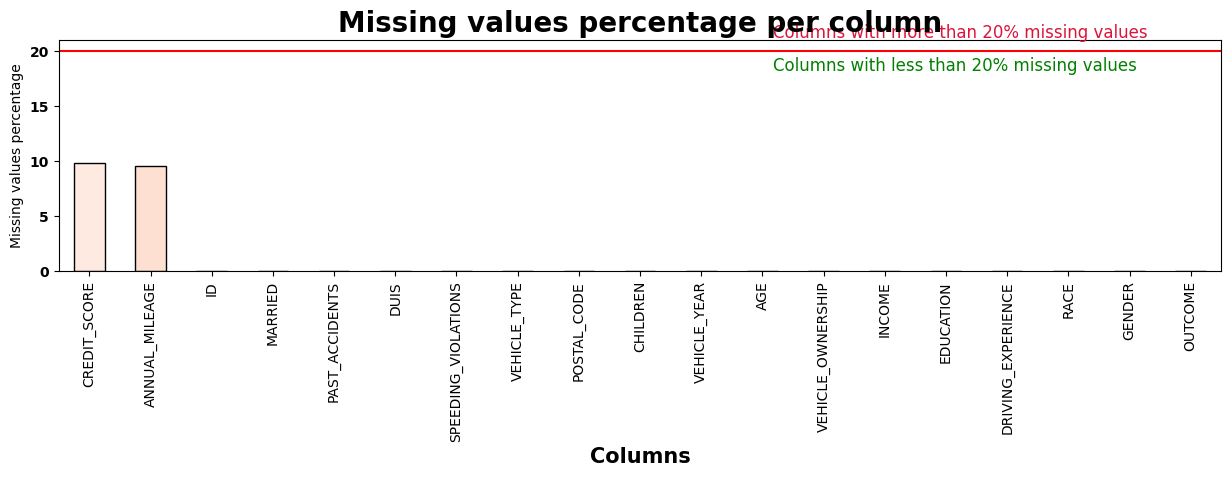

In [8]:
def msv_1(df, thresh = 20, color = 'black', edgecolor = 'black', height = 3, width = 15):
    
    plt.figure(figsize = (width, height))
    percentage = (df.isnull().mean()) * 100
    percentage.sort_values(ascending = False).plot.bar(color = color, edgecolor = edgecolor)
    plt.axhline(y = thresh, color = 'r', linestyle = '-')
    
    plt.title('Missing values percentage per column', fontsize=20, weight='bold' )
    
    plt.text(len(df.isnull().sum()/len(df))/1.7, thresh+2.5, f'Columns with more than {thresh}% missing values', fontsize=12, color='crimson',
         ha='left' ,va='top')
    plt.text(len(df.isnull().sum()/len(df))/1.7, thresh - 0.5, f'Columns with less than {thresh}% missing values', fontsize=12, color='green',
         ha='left' ,va='top')
    plt.xlabel('Columns', size=15, weight='bold')
    plt.ylabel('Missing values percentage')
    plt.yticks(weight ='bold')
    
    return plt.show()
msv_1(df, 20, color=sns.color_palette('Reds',15))

In [9]:
print(f'{df.isnull().any().sum()} столбца в наборе данных по автострахованию с отсутствующими значениями.')

2 столбца в наборе данных по автострахованию с отсутствующими значениями.


> В приведенном выше коде мы сначала проверили, есть ли нулевые значения с помощью функции IsNull(), затем мы берем сумму всех отсутствующих значений с помощью функции sum(), и в результате получаем вывод, что отсутствующих значений нет.



<Axes: >

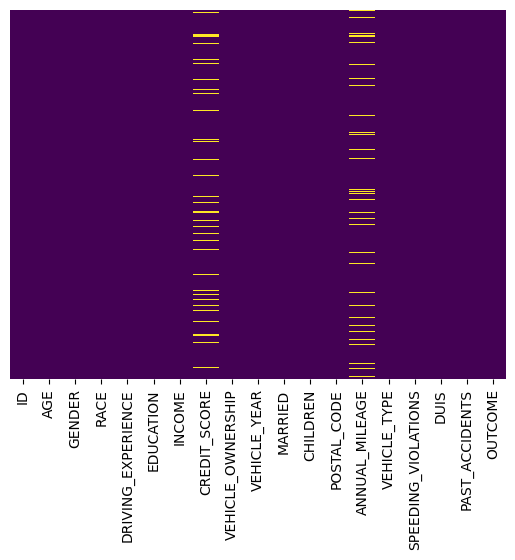

In [10]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [11]:
df.isnull().sum().sort_values(ascending=False)

CREDIT_SCORE           982
ANNUAL_MILEAGE         957
ID                       0
MARRIED                  0
PAST_ACCIDENTS           0
DUIS                     0
SPEEDING_VIOLATIONS      0
VEHICLE_TYPE             0
POSTAL_CODE              0
CHILDREN                 0
VEHICLE_YEAR             0
AGE                      0
VEHICLE_OWNERSHIP        0
INCOME                   0
EDUCATION                0
DRIVING_EXPERIENCE       0
RACE                     0
GENDER                   0
OUTCOME                  0
dtype: int64

## 3.2 Исследование данных

In [12]:
df.OUTCOME.value_counts()

0.0    6867
1.0    3133
Name: OUTCOME, dtype: int64

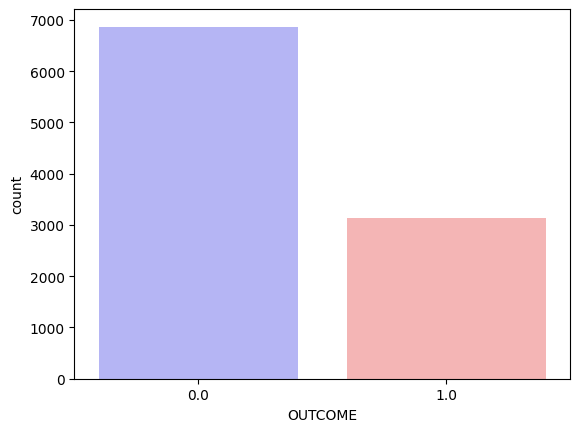

In [13]:
sns.countplot(x="OUTCOME", data=df, palette="bwr")
plt.show()

In [14]:
dont_claim_loan = len(df[df.OUTCOME == 1])
claim_loan = len(df[df.OUTCOME == 0])
print("Процент людей, получивших страховую выплату: {:.2f}%".format((dont_claim_loan / (len(df.OUTCOME))*100)))
print("Процент людей, не получивших страховую выплату: {:.2f}%".format((claim_loan / (len(df.OUTCOME))*100)))

Процент людей, получивших страховую выплату: 31.33%
Процент людей, не получивших страховую выплату: 68.67%


### Графики для анализа набора данных

array([[<Axes: title={'center': 'ID'}>,
        <Axes: title={'center': 'CREDIT_SCORE'}>,
        <Axes: title={'center': 'VEHICLE_OWNERSHIP'}>],
       [<Axes: title={'center': 'MARRIED'}>,
        <Axes: title={'center': 'CHILDREN'}>,
        <Axes: title={'center': 'POSTAL_CODE'}>],
       [<Axes: title={'center': 'ANNUAL_MILEAGE'}>,
        <Axes: title={'center': 'SPEEDING_VIOLATIONS'}>,
        <Axes: title={'center': 'DUIS'}>],
       [<Axes: title={'center': 'PAST_ACCIDENTS'}>,
        <Axes: title={'center': 'OUTCOME'}>, <Axes: >]], dtype=object)

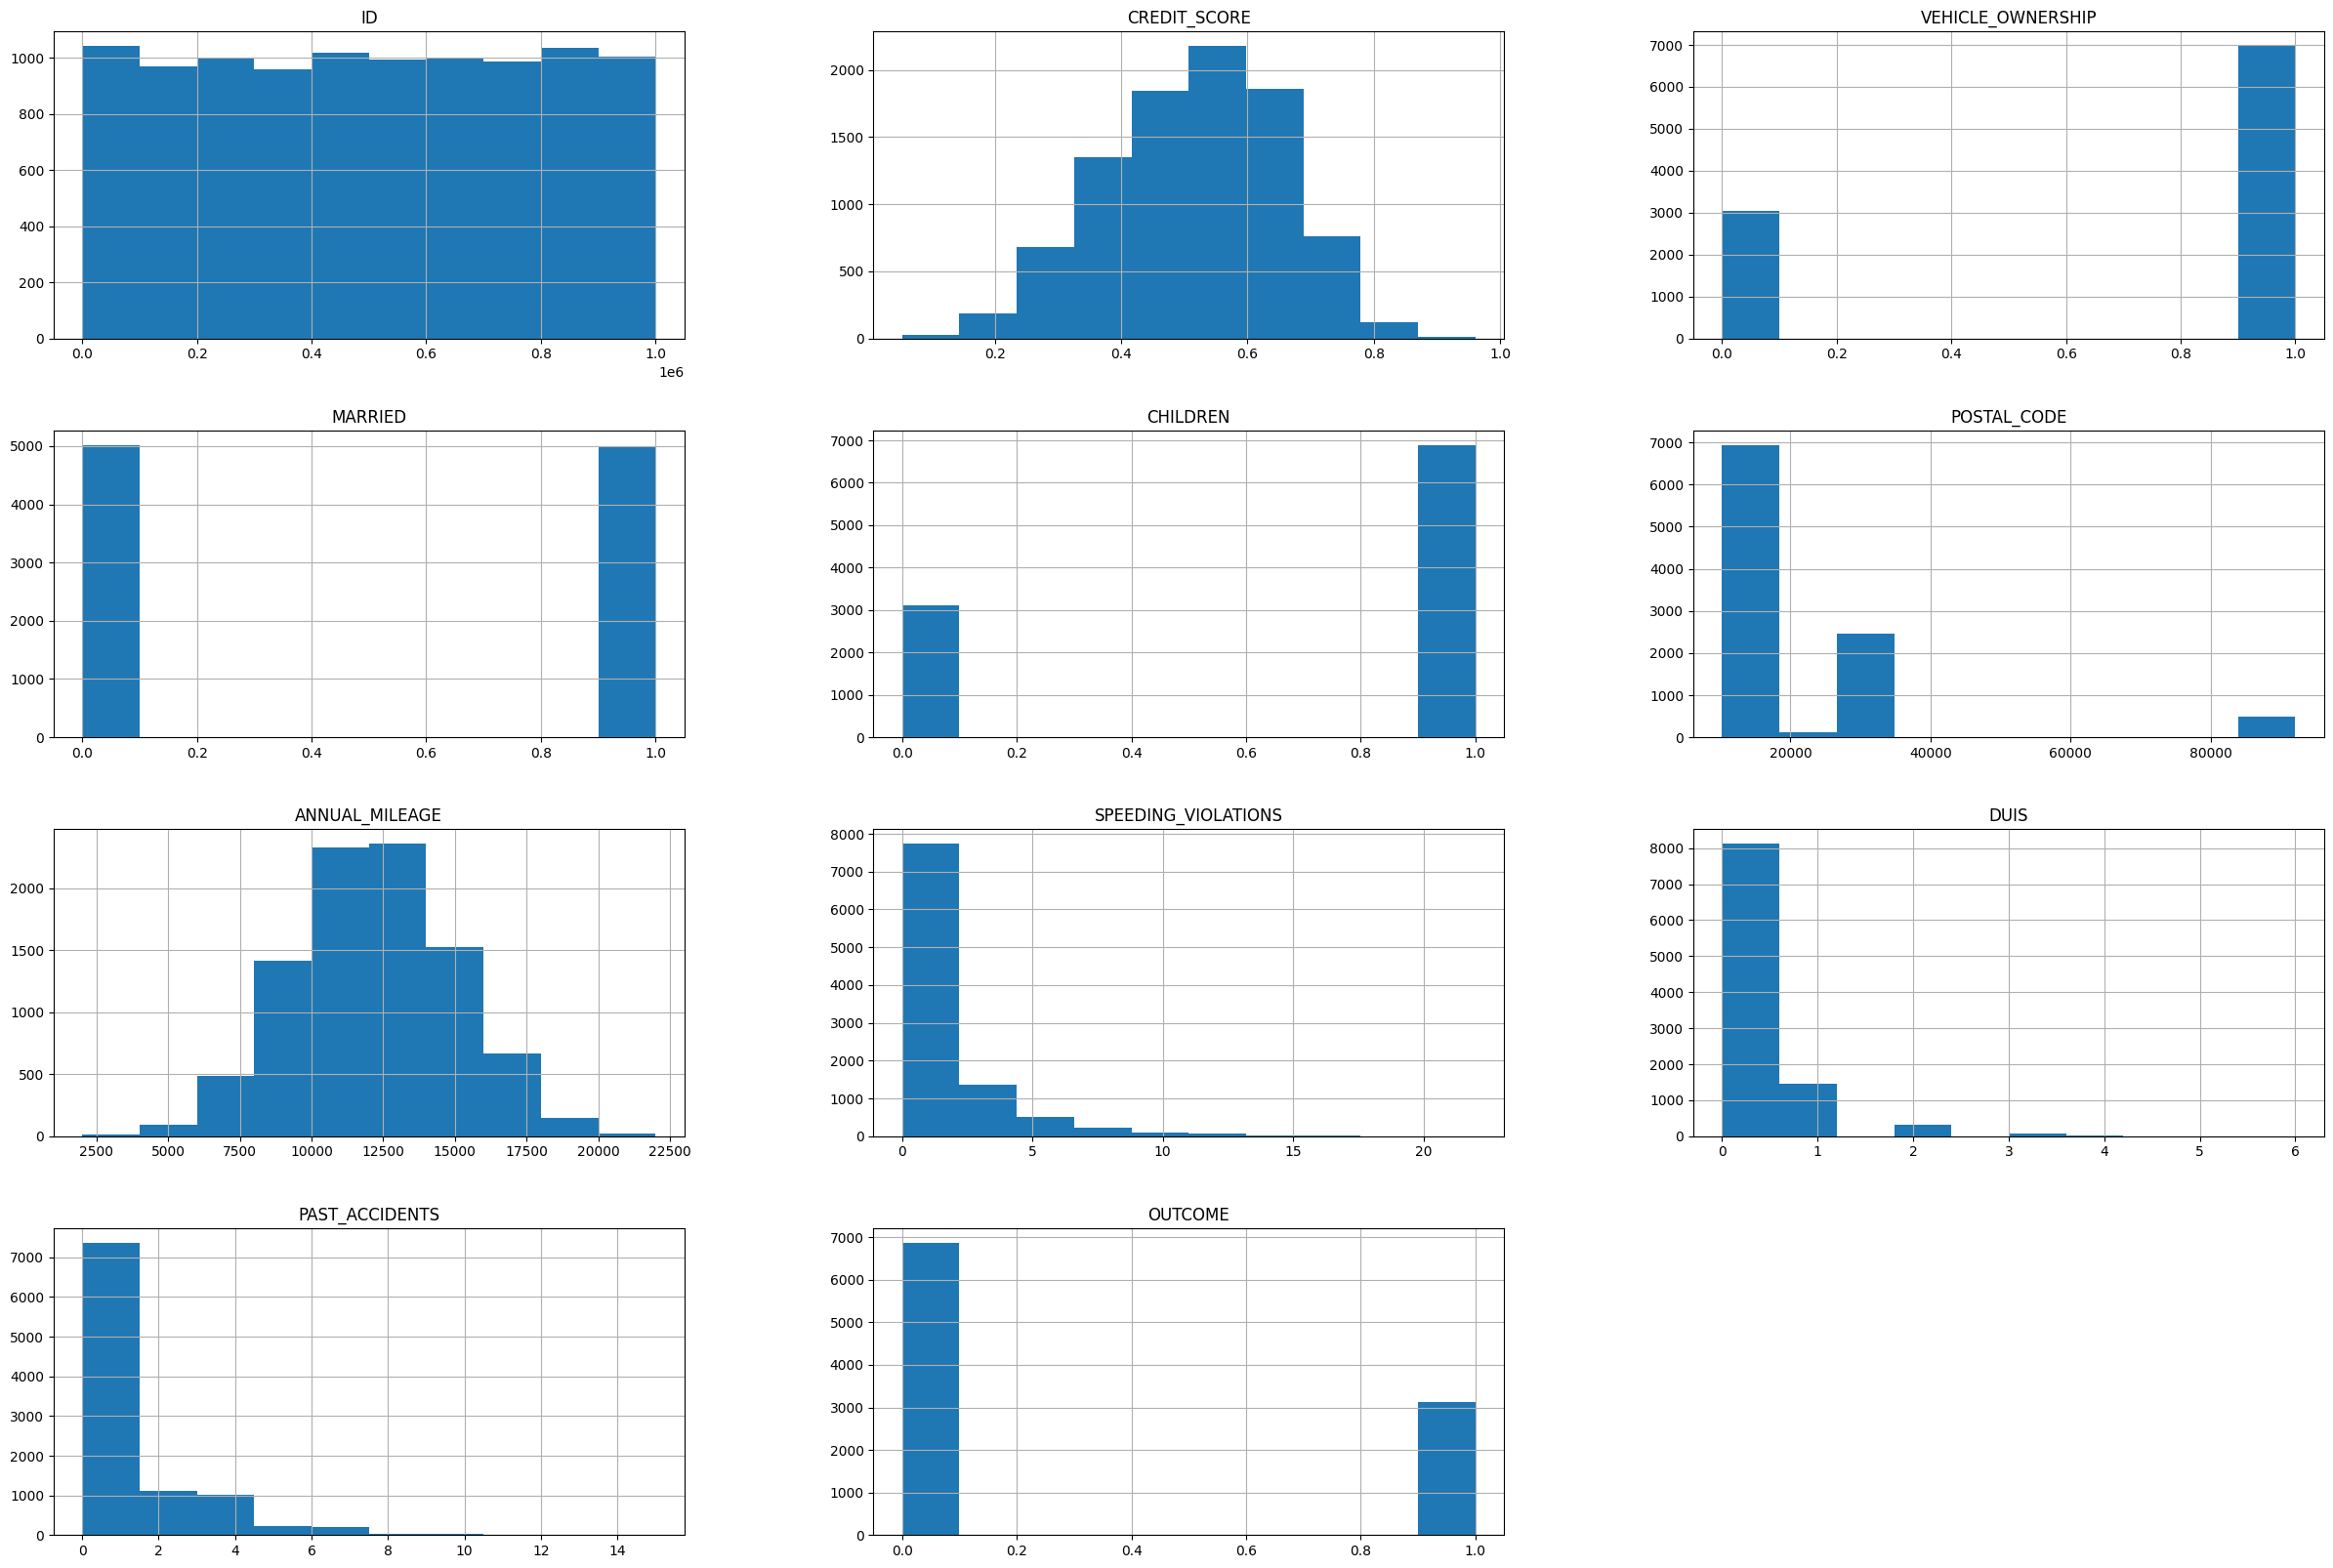

In [15]:
# Гистограммы 
df.hist(figsize=(30,20))

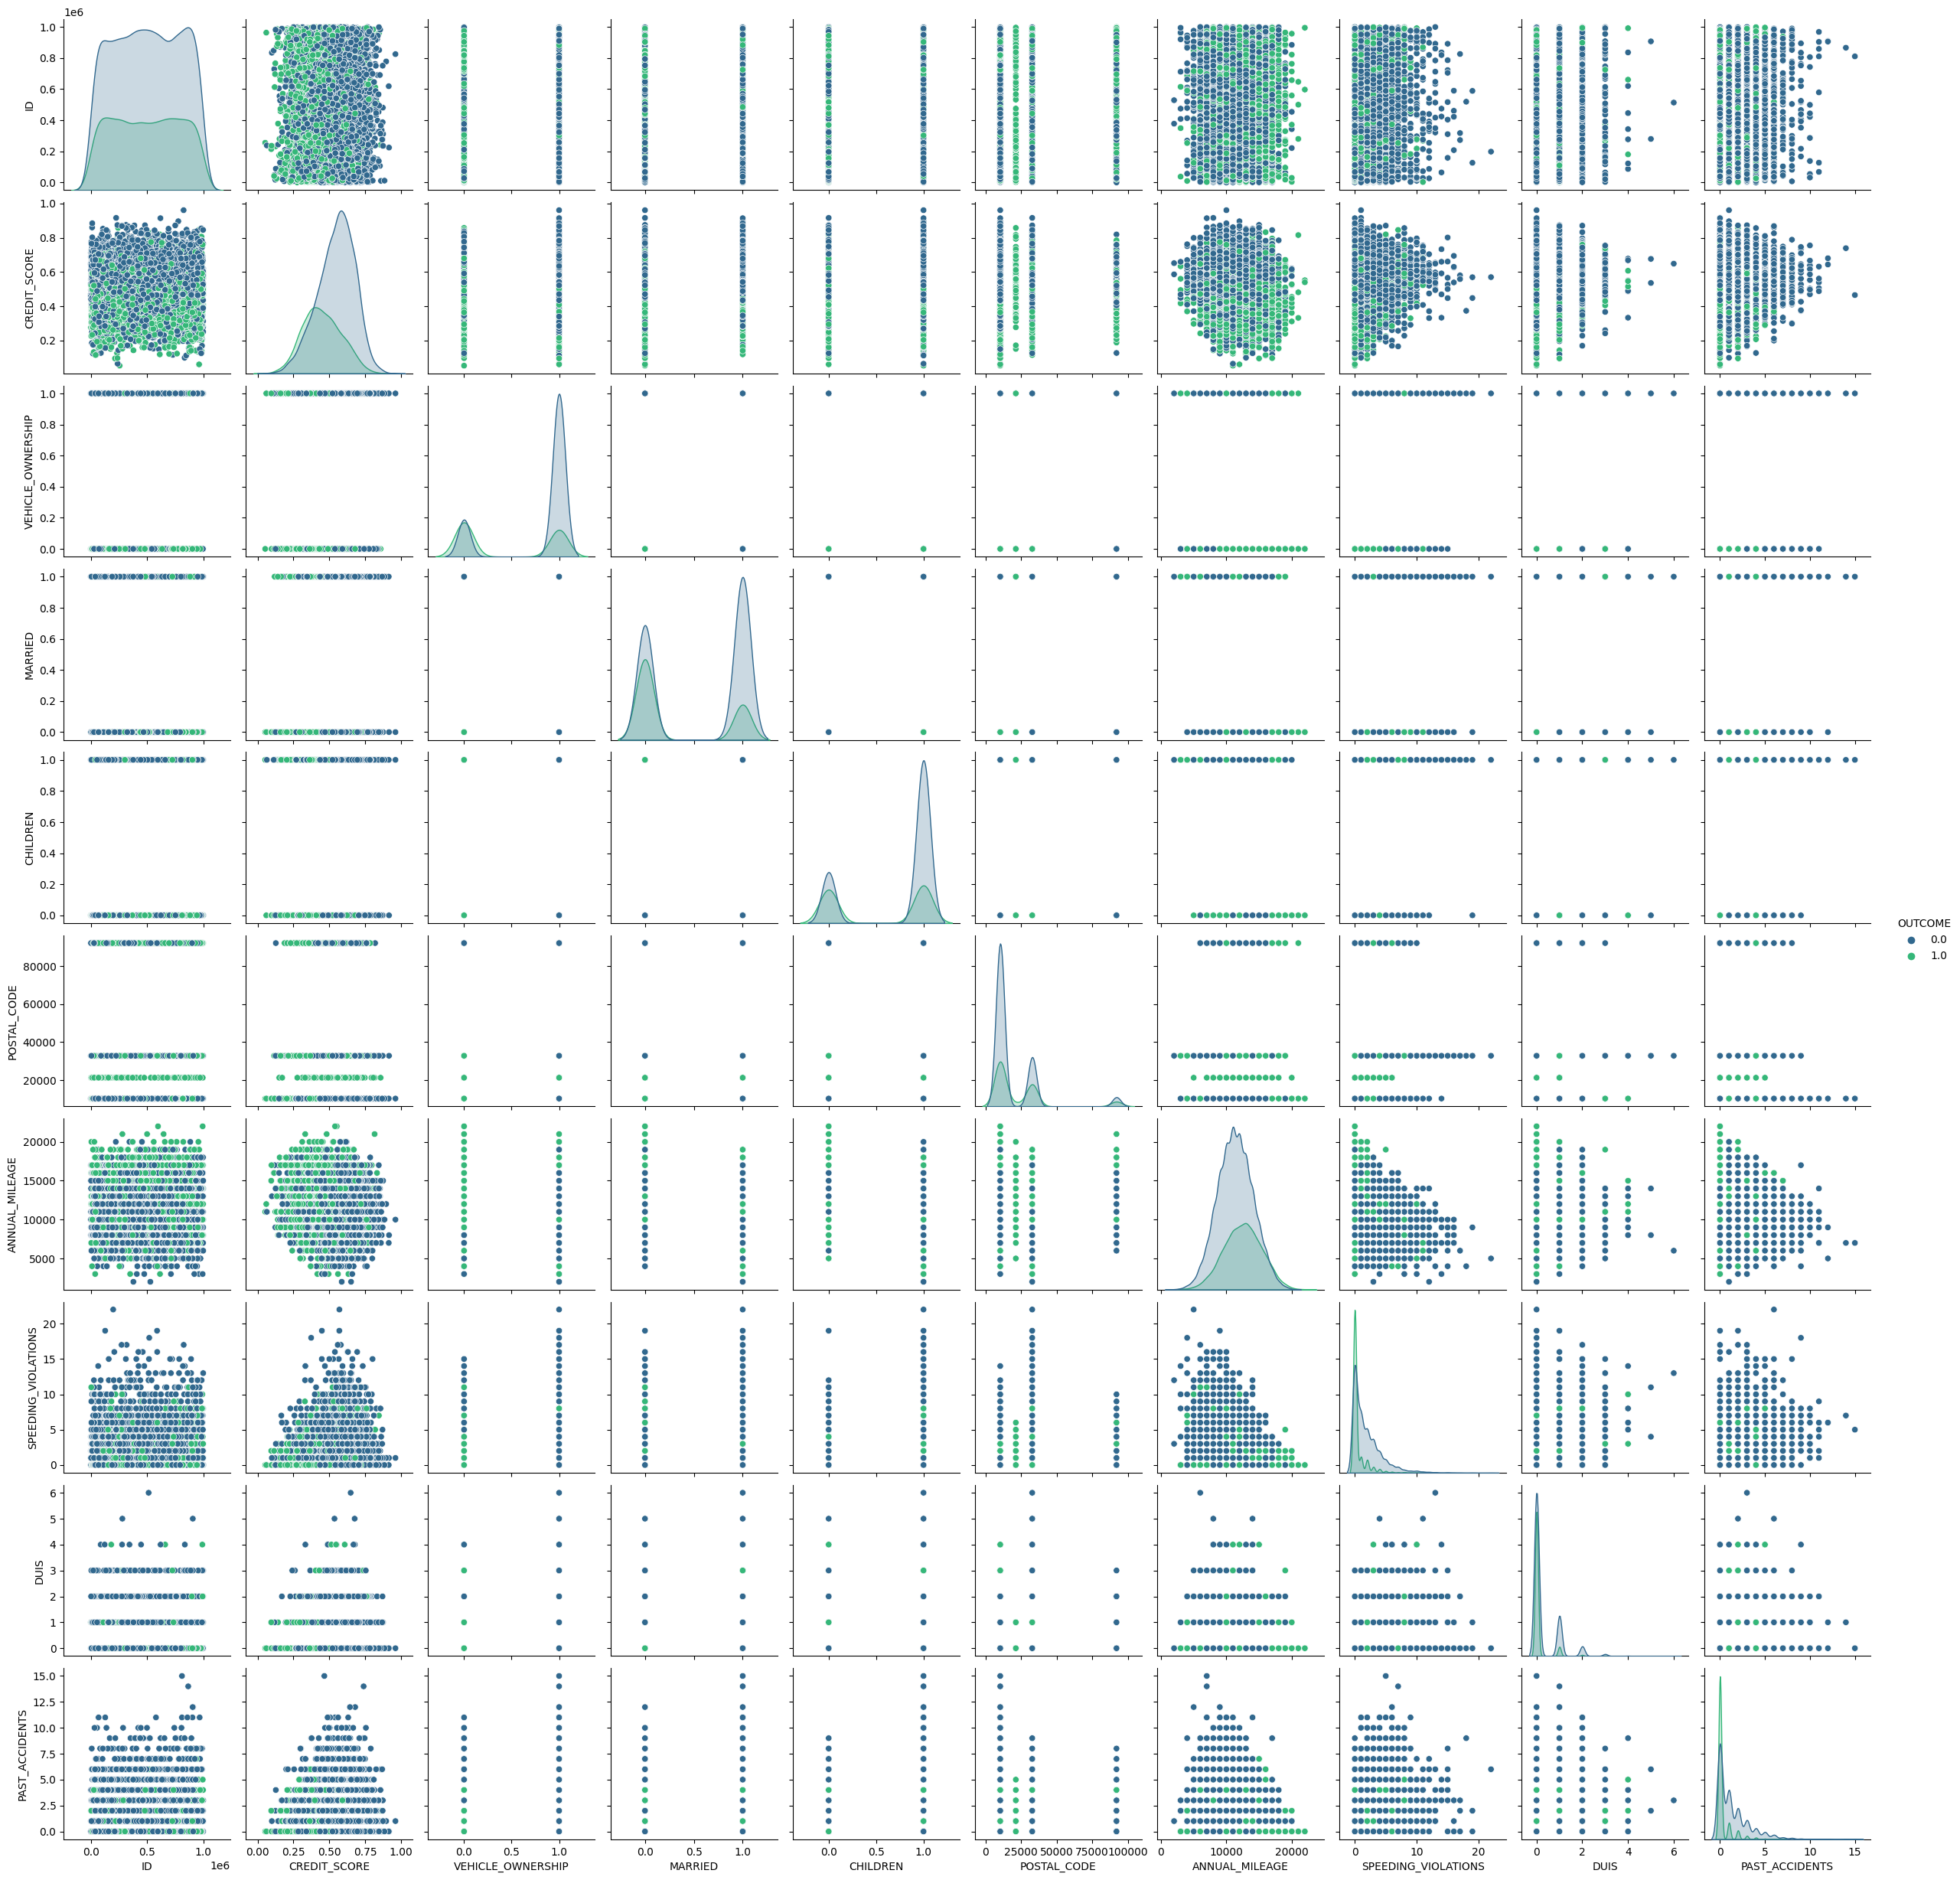

In [16]:
sns.pairplot(df, hue="OUTCOME", palette="viridis");

### **Корреляция с OUTCOME**

In [17]:
df_corr = df.corr().transpose()
df_corr

,ID,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
ID,1.000000,0.001704,0.009197,0.014826,0.001233,0.006038,-0.002217,0.008156,0.009268,0.001831,-0.010506
CREDIT_SCORE,0.001704,1.000000,0.312037,0.281238,0.220658,0.009040,-0.174453,0.204542,0.127366,0.180978,-0.325286
VEHICLE_OWNERSHIP,0.009197,0.312037,1.000000,0.175626,0.125990,-0.004866,-0.097433,0.133868,0.086567,0.119521,-0.378921
MARRIED,0.014826,0.281238,0.175626,1.000000,0.287009,0.012045,-0.462193,0.218855,0.120840,0.215269,-0.262104
CHILDREN,0.001233,0.220658,0.125990,0.287009,1.000000,0.020911,-0.447655,0.220415,0.115354,0.206295,-0.232835
POSTAL_CODE,0.006038,0.009040,-0.004866,0.012045,0.020911,1.000000,-0.133978,0.113686,0.038492,-0.116985,0.095889
ANNUAL_MILEAGE,-0.002217,-0.174453,-0.097433,-0.462193,-0.447655,-0.133978,1.000000,-0.323547,-0.116598,-0.195217,0.187154
SPEEDING_VIOLATIONS,0.008156,0.204542,0.133868,0.218855,0.220415,0.113686,-0.323547,1.000000,0.359838,0.443074,-0.291862
DUIS,0.009268,0.127366,0.086567,0.120840,0.115354,0.038492,-0.116598,0.359838,1.000000,0.259359,-0.189352
PAST_ACCIDENTS,0.001831,0.180978,0.119521,0.215269,0.206295,-0.116985,-0.195217,0.443074,0.259359,1.000000,-0.311495


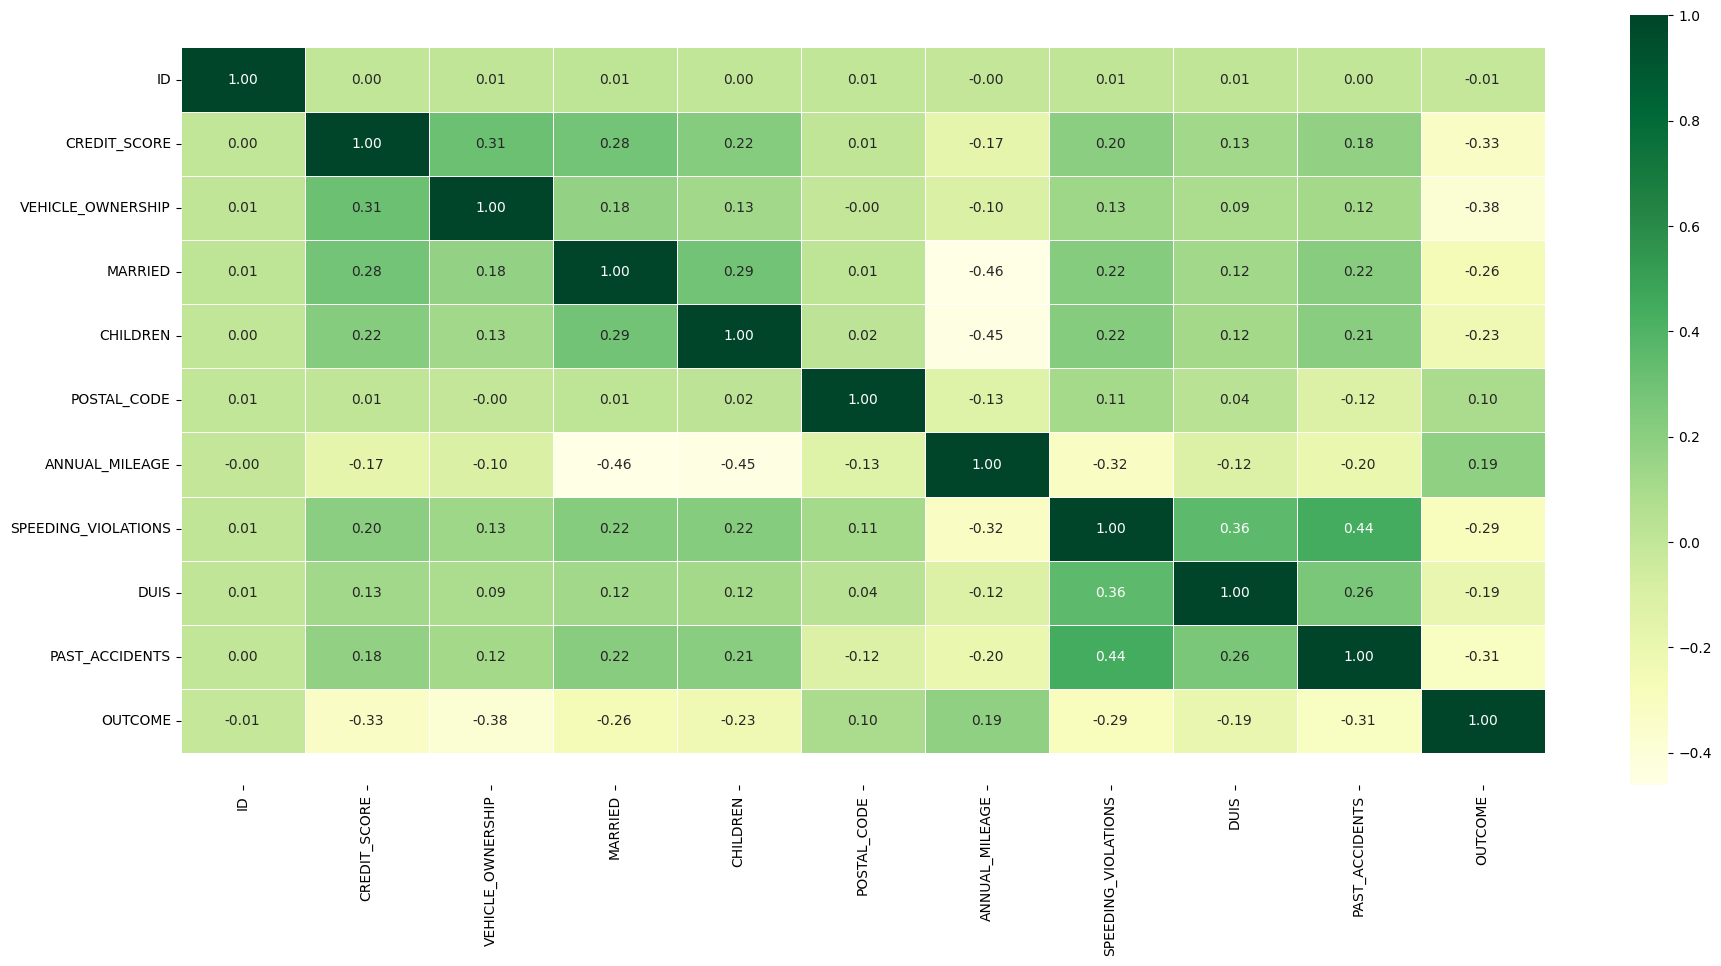

In [18]:
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(22, 10))
ax = sns.heatmap(corr_matrix,annot=True,linewidths=0.5,fmt=".2f",cmap="YlGn");
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

График корреляции показывает связь между параметрами.


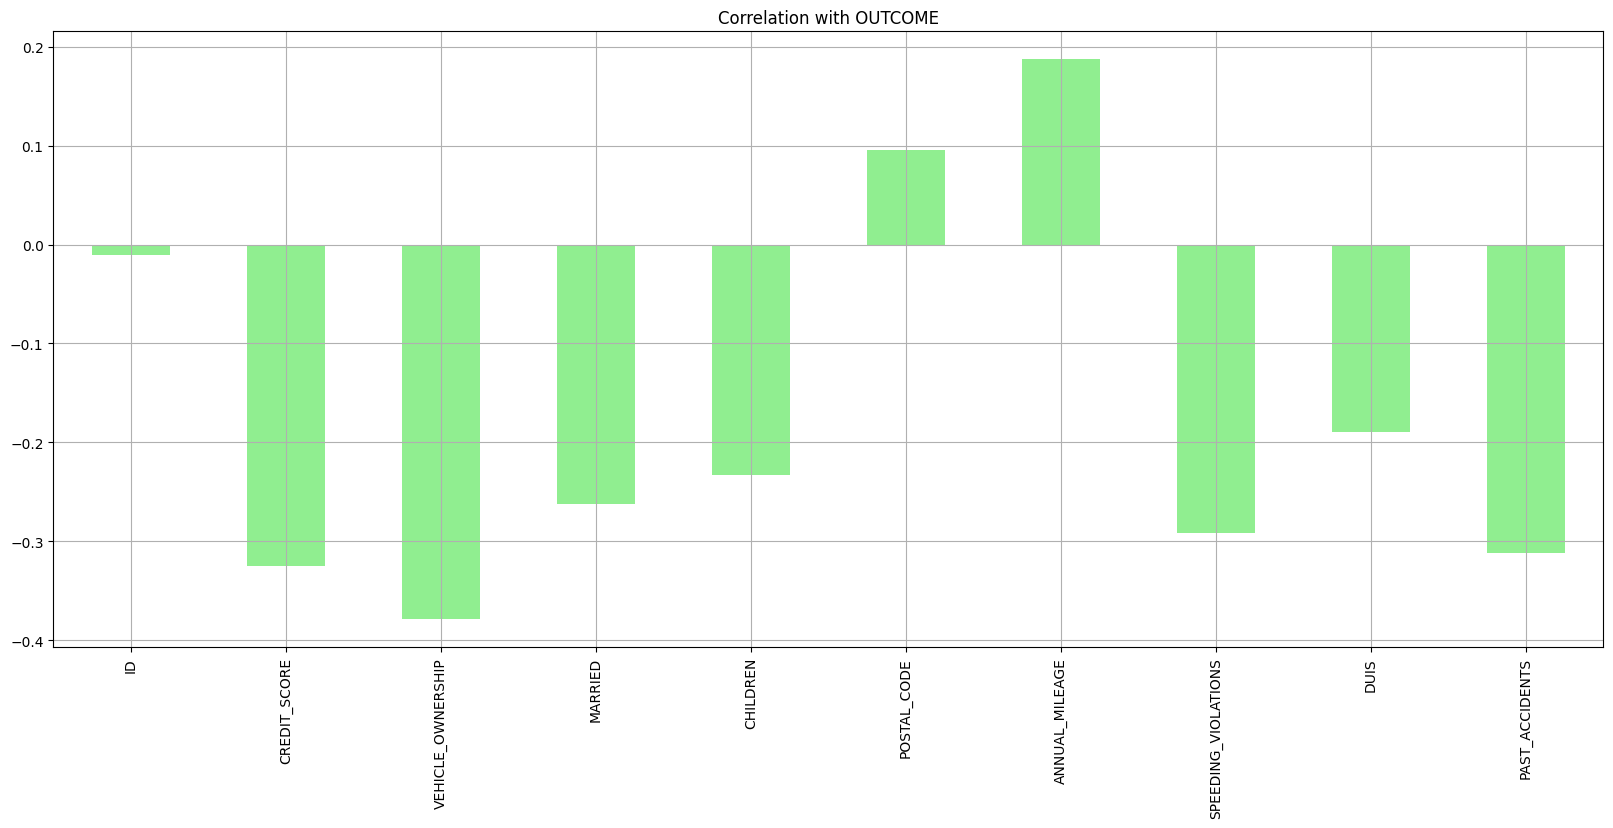

In [19]:
df.drop('OUTCOME', axis=1).corrwith(df.OUTCOME).plot(kind='bar', grid=True, figsize=(20, 8), title="Correlation with OUTCOME",color="lightgreen");

---
***Наблюдения на основе корреляции:***
- *``POSTAL_CODE``, ``ID`` наименее коррелируют с переменной OUTCOME.*
- *Все остальные переменные имеют значительную корреляцию с переменной OUTCOME.*
---


### Взаимосвязь между AGE и OUTCOME

In [20]:
df["AGE"].replace({"16-25": "Young", "26-39": "Middle_Age","40-64":"Old","65+":"Very_Old"}, inplace=True)

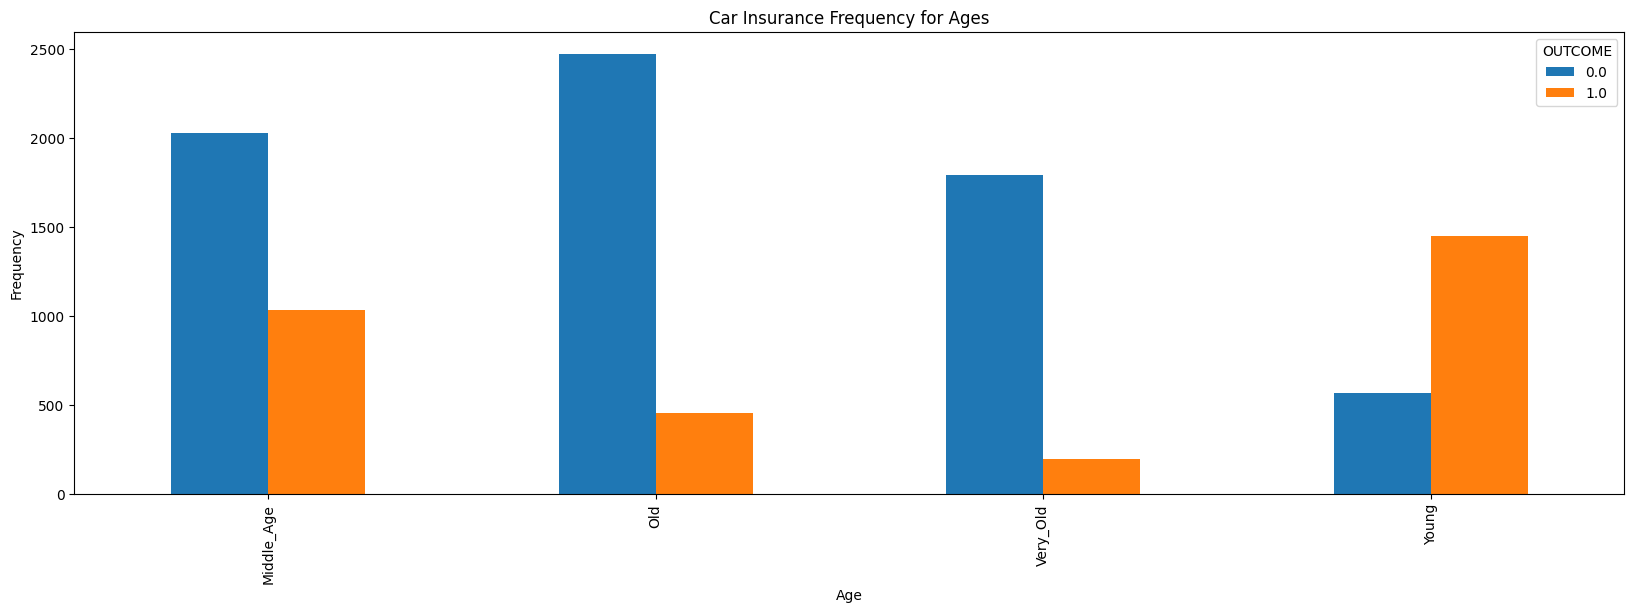

In [21]:
pd.crosstab(df.AGE,df.OUTCOME).plot(kind="bar",figsize=(20,6))
plt.title('Car Insurance Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Здесь ``Young`` люди чаще претендуют на страховую выплату

In [22]:
pd.crosstab(df["OUTCOME"], df["AGE"])

AGE,Middle_Age,Old,Very_Old,Young
OUTCOME,,,,
0.0,2031,2474,1794,568
1.0,1032,457,196,1448


> Как мы видим, возраст оказывает значительное влияние на данные car_insurance_data, причем наибольшее влияние наблюдается между возрастами ``Middle_Age`` и ``Old``.

### Взаимосвязь между GENDER и OUTCOME

Text(0.5, 1.0, 'Car_Insurance_Data Frequency for Gender')

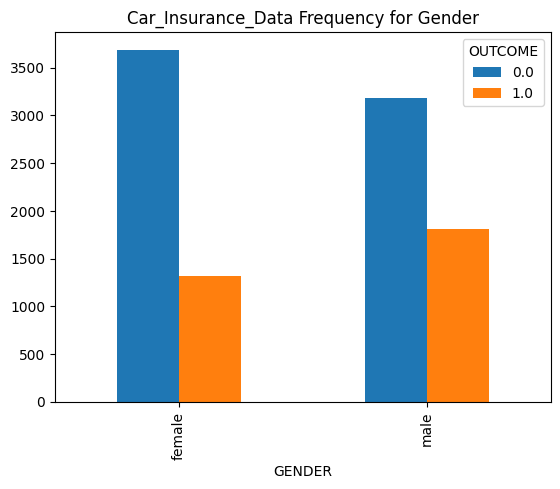

In [23]:
pd.crosstab(df.GENDER, df.OUTCOME).plot(kind = 'bar')
plt.title("Car_Insurance_Data Frequency for Gender")

In [24]:
pd.crosstab(df["OUTCOME"], df["GENDER"])

GENDER,female,male
OUTCOME,,
0.0,3689,3178
1.0,1321,1812


> Согласно таблице, мужчины чаще претендуют на страховые выплаты, чем женщины.

### Взаимосвязь INCOME и OUTCOME

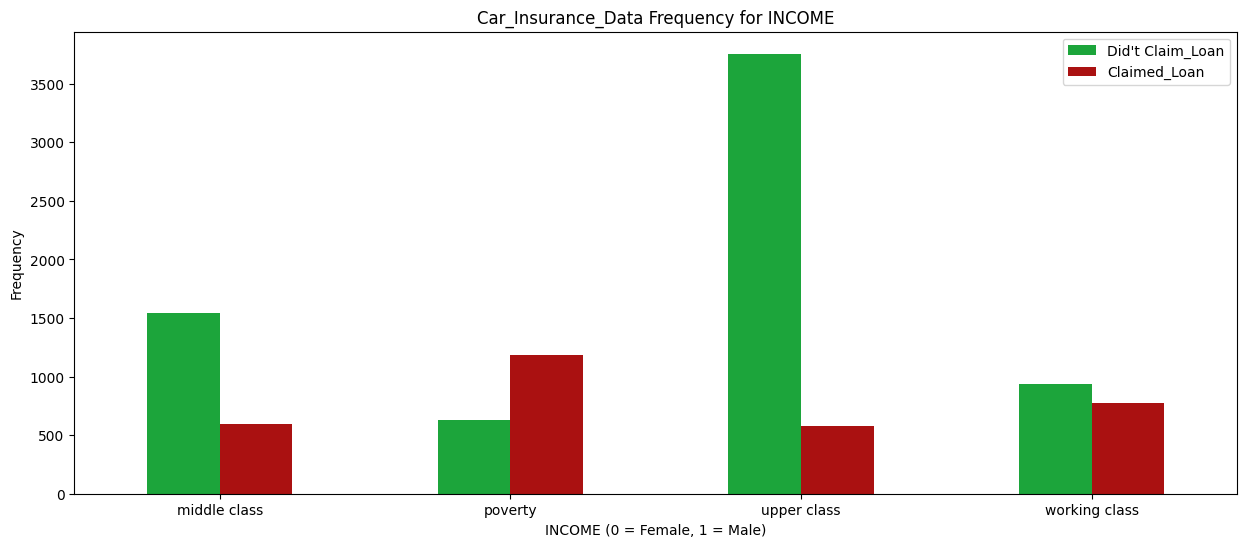

In [25]:
pd.crosstab(df.INCOME,df.OUTCOME).plot(kind="bar",figsize=(15,6),color=['#1CA53B','#AA1111', '#FFA500' ])
plt.title('Car_Insurance_Data Frequency for INCOME')
plt.xlabel('INCOME (0 = Female, 1 = Male)')
plt.xticks(rotation=0)
plt.legend(["Did't Claim_Loan", "Claimed_Loan"])
plt.ylabel('Frequency')
plt.show()

In [26]:
pd.crosstab(df["OUTCOME"], df["INCOME"])

INCOME,middle class,poverty,upper class,working class
OUTCOME,,,,
0.0,1546,628,3757,936
1.0,592,1186,579,776


> Мы можем наблюдать, что представители бедного класса чаще обращаются за страховыми выплатами, а представители высшего класса - реже.

### Взаимосвязь между EDUCATION и OUTCOME



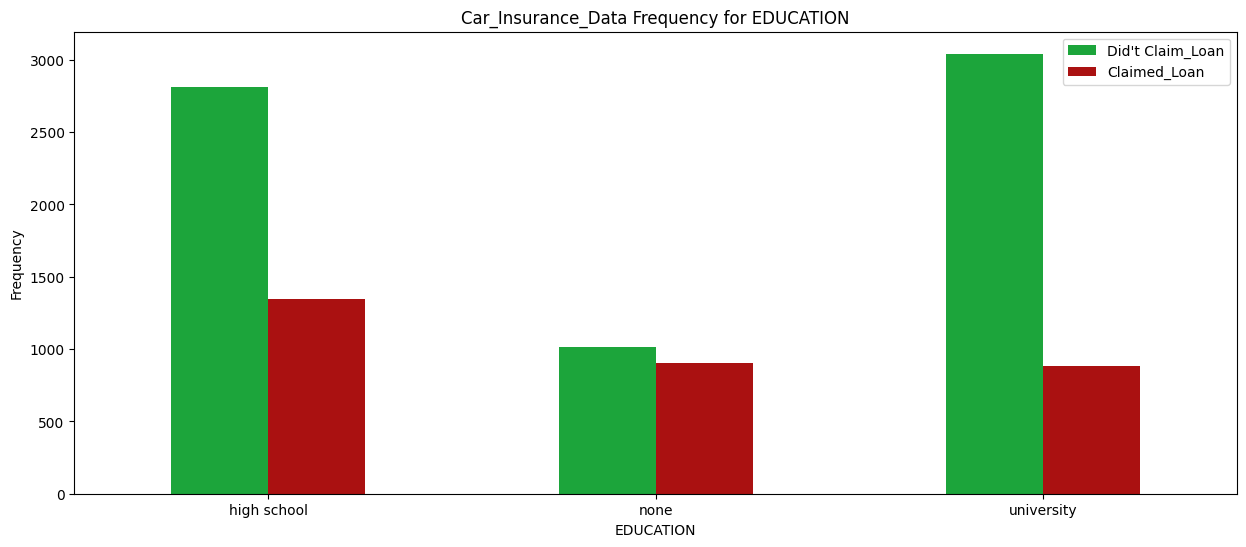

In [27]:
pd.crosstab(df.EDUCATION,df.OUTCOME).plot(kind="bar",figsize=(15,6),color=['#1CA53B','#AA1111', '#FFA500' ])
plt.title('Car_Insurance_Data Frequency for EDUCATION')
plt.xlabel('EDUCATION')
plt.xticks(rotation=0)
plt.legend(["Did't Claim_Loan", "Claimed_Loan"])
plt.ylabel('Frequency')
plt.show()

In [28]:
pd.crosstab(df["OUTCOME"], df["EDUCATION"])

EDUCATION,high school,none,university
OUTCOME,,,
0.0,2813,1012,3042
1.0,1344,903,886


> Старшеклассники чаще заявляют о страховых выплатах.

### Взаимосвязь между DRIVING_EXPERIENCE и OUTCOME

In [29]:
df["DRIVING_EXPERIENCE"].replace({"0-9y": "Newbie", "10-19y": "Amateur","20-29y":"Advanced","30y+":"Expert"}, inplace=True)

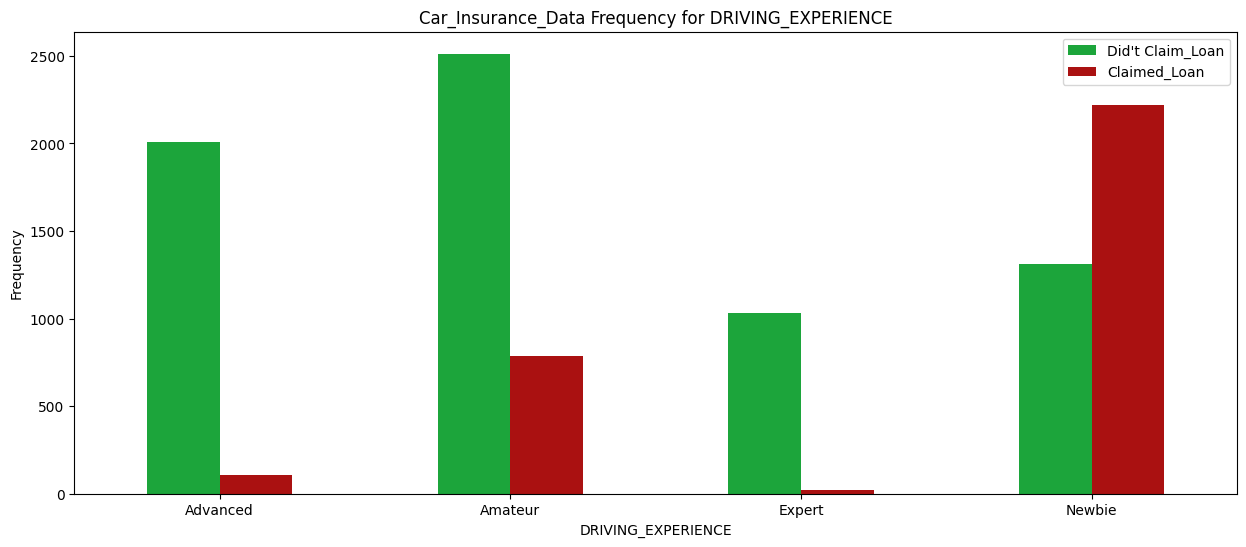

In [30]:
pd.crosstab(df.DRIVING_EXPERIENCE,df.OUTCOME).plot(kind="bar",figsize=(15,6),color=['#1CA53B','#AA1111', '#FFA500' ])
plt.title('Car_Insurance_Data Frequency for DRIVING_EXPERIENCE')
plt.xlabel('DRIVING_EXPERIENCE')
plt.xticks(rotation=0)
plt.legend(["Did't Claim_Loan", "Claimed_Loan"])
plt.ylabel('Frequency')
plt.show()

In [31]:
pd.crosstab(df["OUTCOME"], df["DRIVING_EXPERIENCE"])

DRIVING_EXPERIENCE,Advanced,Amateur,Expert,Newbie
OUTCOME,,,,
0.0,2010,2512,1032,1313
1.0,109,787,20,2217


> Водитель-новичок с большим отрывом перекрыл кредит.

# 4. Предварительная обработка

### 4.1 Чистка данных

In [32]:
df.isnull().sum().sort_values(ascending=False)

CREDIT_SCORE           982
ANNUAL_MILEAGE         957
ID                       0
MARRIED                  0
PAST_ACCIDENTS           0
DUIS                     0
SPEEDING_VIOLATIONS      0
VEHICLE_TYPE             0
POSTAL_CODE              0
CHILDREN                 0
VEHICLE_YEAR             0
AGE                      0
VEHICLE_OWNERSHIP        0
INCOME                   0
EDUCATION                0
DRIVING_EXPERIENCE       0
RACE                     0
GENDER                   0
OUTCOME                  0
dtype: int64

In [33]:
def fillna(dataframe,feature_cols):
    total_cols=0
    for y in feature_cols:
        total_cols+=1
        if dataframe[y].isna().sum()>1:
            try:
                dataframe[y]=dataframe[y].fillna(int(np.mean(dataframe[y])))
            except ValueError:
                pass
        else:
            continue

feature_cols=["CREDIT_SCORE","ANNUAL_MILEAGE"]
fillna(df,feature_cols)

### 4.2 Разделение данных

In [34]:
X = df.drop(['OUTCOME','ID'], axis=1)
y = df['OUTCOME']
X = pd.get_dummies(X, drop_first=True)

In [35]:
# Разделение данных на обучающее и тестовое множество:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Обобщить распределение классов в наборе данных для обучения
counter = Counter(y_train)
print(counter)

Counter({0.0: 5500, 1.0: 2500})


> Распределение наблюдений в целевом классе перекошено (несбалансированные данные).

### 4.3 Масштабирование признаков

In [37]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### 4.4 Работа с выборкой

In [38]:
# Преобразование обучающего набора данных
oversample = SMOTE(random_state=33)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [39]:
# Суммировать новое распределение классов в наборе данных для обучения
counter = Counter(y_train)
print(counter)

Counter({0.0: 5500, 1.0: 5500})


> Теперь данные сбалансированы

# 5. Настройка гиперпараметров

### 5.1 Настройка моделей

> GridSearchCV - это библиотечная функция, входящая в пакет sklearn's model_selection. Она помогает перебирать предопределенные гиперпараметры и подгонять оценку (модель) к обучающему множеству. В итоге вы можете выбрать лучшие параметры из списка гиперпараметров.

In [40]:
from sklearn.model_selection import GridSearchCV

In [41]:
grid_models = [(LogisticRegression(),[{'C':[0.25,0.5,0.75,1],'random_state':[0]}]), 
               (RandomForestClassifier(),[{'n_estimators':[100,150,200],'criterion':['gini','entropy'],'random_state':[0]}]),
               (GradientBoostingClassifier(),[{'n_estimators':[100,150,200],'criterion':['friedman_mse','mse'],'loss':['deviance','exponential'],'learning_rate':[0.1, 0.5, 0.8, 1],'random_state':[0]}])]

In [42]:
for i,j in grid_models:
    grid = GridSearchCV(estimator=i,param_grid = j, scoring = 'accuracy',cv=2)
    grid.fit(X_train, y_train)
    best_accuracy = grid.best_score_
    best_param = grid.best_params_
    print('{}:\nНаилучшая точность : {:.2f}%'.format(i,best_accuracy*100))
    print('Лучшие параметры : ',best_param)
    print('')
    print('----------------')
    print('')

LogisticRegression():
Наилучшая точность : 83.35%
Лучшие параметры :  {'C': 0.75, 'random_state': 0}

----------------

RandomForestClassifier():
Наилучшая точность : 87.13%
Лучшие параметры :  {'criterion': 'entropy', 'n_estimators': 150, 'random_state': 0}

----------------

GradientBoostingClassifier():
Наилучшая точность : 85.24%
Лучшие параметры :  {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'exponential', 'n_estimators': 100, 'random_state': 0}

----------------



## 5.2 Модели после настройки гиперпараметров 

После поиска по сетке мы получили наилучшие параметры для всех моделей. Теперь мы собираемся настроить гиперпараметры и посмотреть, как они работают. <br>

***True Positives (TP)*** - Это правильно предсказанные положительные значения, что означает, что значение фактического класса - да, и значение предсказанного класса - тоже да.. <br>

***True Negatives (TN)*** - Это правильно предсказанные отрицательные значения, что означает, что значение фактического класса равно "нет" и значение предсказанного класса также равно "нет".. <br>

***False Positives (FP)*** – Когда фактический класс - нет, а прогнозируемый - да. <br>

***False Negatives (FN)*** – Когда фактический класс - да, а прогнозируемый - нет. <br>

***Accuracy*** - Точность является наиболее интуитивно понятной мерой производительности и представляет собой просто отношение правильно предсказанного наблюдения к общему количеству наблюдений.. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Accuracy = TP+TN/TP+FP+FN+TN** <br>

***Precision*** - Точность - это отношение правильно предсказанных положительных наблюдений к общему количеству предсказанных положительных наблюдений. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Precision = TP/TP+FP** <br>

***Recall (Sensitivity)*** - Recall - это отношение правильно предсказанных положительных наблюдений ко всем наблюдениям в реальном классе - да. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Recall = TP/TP+FN** <br>

 ***F1 score*** - F1 Score - это средневзвешенное значение Precision и Recall. Таким образом, этот показатель учитывает как ложноположительные, так и ложноотрицательные результаты. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**F1 Score = 2*(Recall * Precision) / (Recall + Precision)** <br>

 ***Support*** - Поддержка - это количество фактических вхождений класса в указанный набор данных. Поддержка не меняется между моделями, а диагностирует процесс оценки. 

### Logistic Regression

              precision    recall  f1-score   support

         0.0       0.91      0.82      0.86      1367
         1.0       0.68      0.82      0.74       633

    accuracy                           0.82      2000
   macro avg       0.79      0.82      0.80      2000
weighted avg       0.84      0.82      0.83      2000

ROC AUC score: 0.8994644699998035
Accuracy Score:  0.8215
F1 Score:  0.7444523979957052


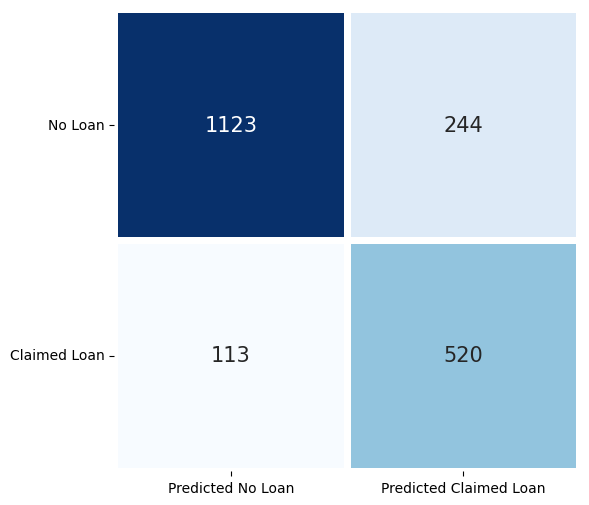

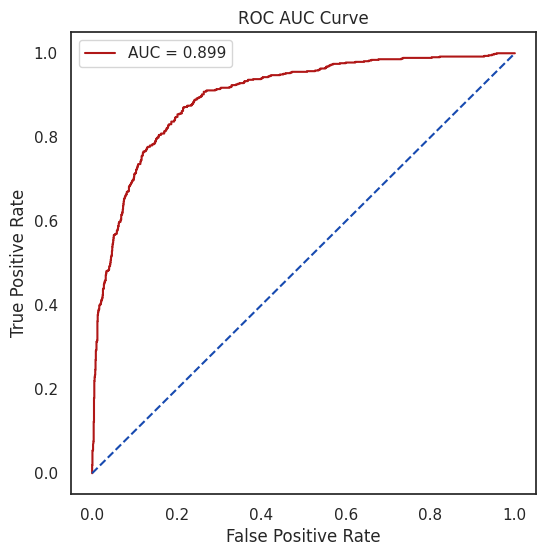

In [43]:
# Подгонка модели логистической регрессии
accuracies = {}
classifier = LogisticRegression(C= 0.75, random_state= 0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {roc_auc_score(y_test, y_prob)}')
print('Accuracy Score: ', accuracy_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))

# Визуализация матрицы ошибок
plt.figure(figsize = (6, 6))
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No Loan', 'Claimed Loan'], xticklabels = ['Predicted No Loan', 'Predicted Claimed Loan'])
plt.yticks(rotation = 0)
plt.show()

# Точность
acc = accuracy_score(y_test, y_pred)*100
accuracies['Logistic Regression'] = acc

# Roc AUC кривая
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (6, 6))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC AUC Curve')
plt.legend()
plt.show()

> Точность тестирования алгоритма логистической регрессии составляет 82,15%

### Random Forest

              precision    recall  f1-score   support

         0.0       0.87      0.89      0.88      1367
         1.0       0.75      0.70      0.73       633

    accuracy                           0.83      2000
   macro avg       0.81      0.80      0.80      2000
weighted avg       0.83      0.83      0.83      2000

ROC AUC score: 0.9039859657394855
Accuracy Score:  0.8325
F1 Score:  0.7269763651181744


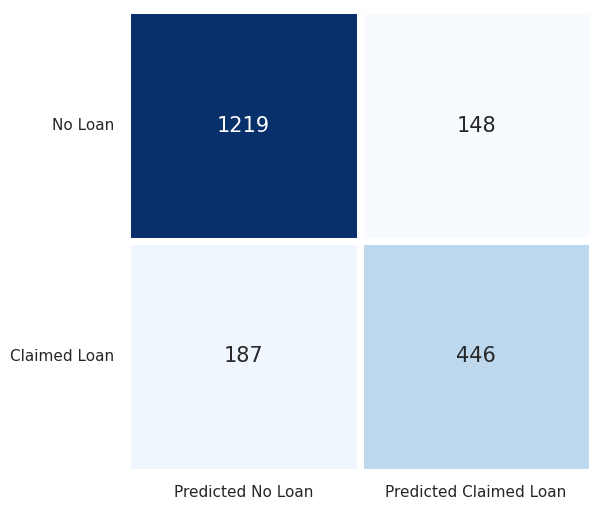

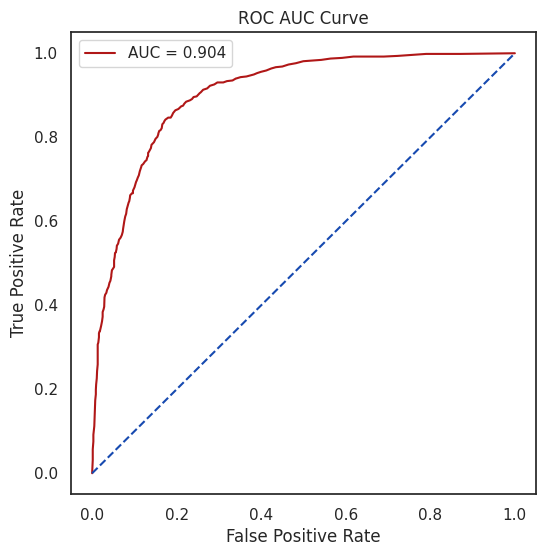

In [44]:
# Настройка RandomForestClassifier Model
classifier = RandomForestClassifier(criterion= 'entropy', n_estimators= 150, random_state= 0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {roc_auc_score(y_test, y_prob)}')
print('Accuracy Score: ',accuracy_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))


# Визуализация матрицы ошибок
plt.figure(figsize = (6, 6))
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No Loan', 'Claimed Loan'], xticklabels = ['Predicted No Loan', 'Predicted Claimed Loan'])
plt.yticks(rotation = 0)
plt.show()

# Roc AUC кривая
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

# Точность
acc = accuracy_score(y_test, y_pred)*100
accuracies['Random Forest'] = acc



sns.set_theme(style = 'white')
plt.figure(figsize = (6, 6))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC AUC Curve')
plt.legend()
plt.show()

> Точность тестирования алгоритма Random Forest составляет 83,25%.



### Gradient Boost

              precision    recall  f1-score   support

         0.0       0.90      0.89      0.89      1367
         1.0       0.76      0.78      0.77       633

    accuracy                           0.85      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.85      0.85      0.85      2000

ROC AUC score: 0.9217004059812021
Accuracy Score:  0.8535
F1 Score:  0.7709147771696637


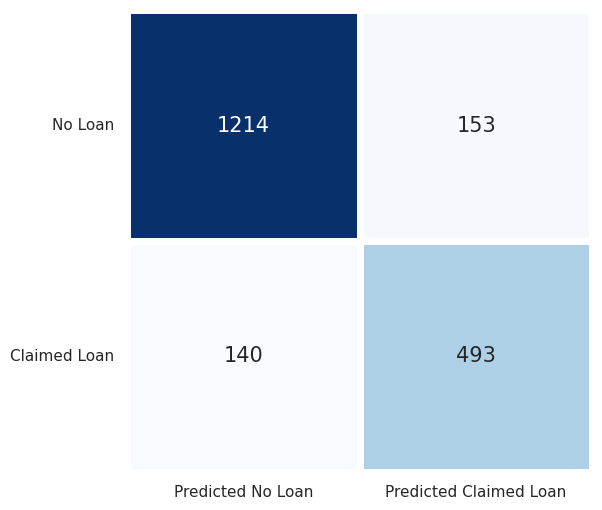

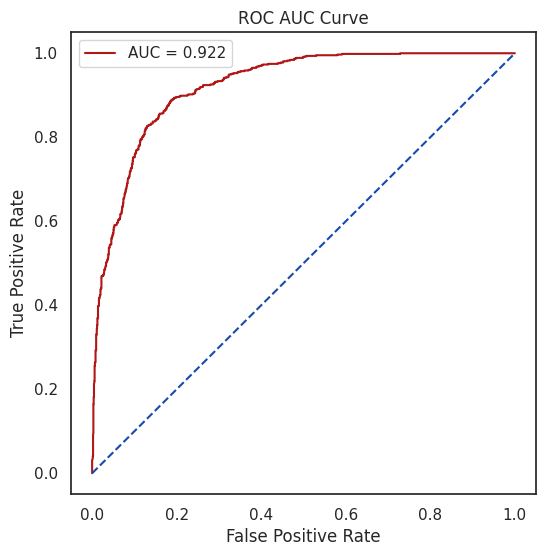

In [45]:
# Настройка GradientBoostingClassifier Model
classifier = GradientBoostingClassifier(criterion= 'friedman_mse', learning_rate= 0.1, loss= 'exponential', n_estimators= 100, random_state= 0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {roc_auc_score(y_test, y_prob)}')
print('Accuracy Score: ',accuracy_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))


# Визуализация матрицы ошибок
plt.figure(figsize = (6, 6))
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No Loan', 'Claimed Loan'], xticklabels = ['Predicted No Loan', 'Predicted Claimed Loan'])
plt.yticks(rotation = 0)
plt.show()

# Roc AUC кривая
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

# Точность
acc = accuracy_score(y_test, y_pred)*100
accuracies['Gradient Boost'] = acc

sns.set_theme(style = 'white')
plt.figure(figsize = (6, 6))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC AUC Curve')
plt.legend()
plt.show()

> Точность тестирования алгоритма Gradient Boost составляет 85,35%.

### Сравнение моделей

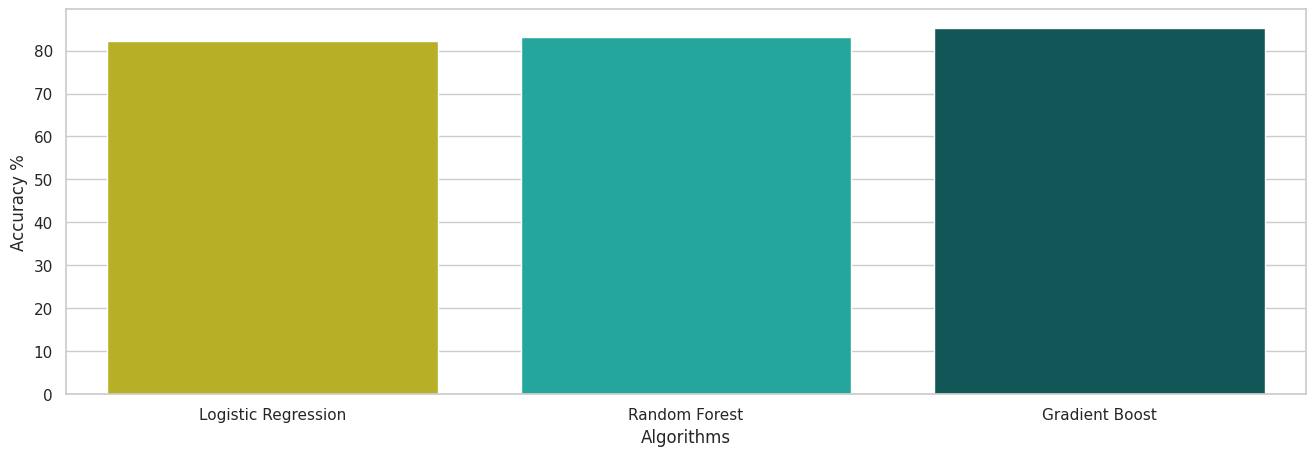

In [46]:
colors = ["#CFC60E", "#0FBBAE", "#066163", "magenta","#CFC60E","#0FBBAE",'#417D7A','#066163','#4D4C7D']

sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Accuracy %")
plt.xlabel("Algorithms")
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette=colors)
plt.show()

In [47]:
df_tuned = pd.DataFrame(accuracies.items(), columns=['Model', 'Accuracy'])
df_tuned.sort_values(by= ['Accuracy'], inplace= True, ascending= False)
df_tuned

,Model,Accuracy
2,Gradient Boost,85.35
1,Random Forest,83.25
0,Logistic Regression,82.15


# Вывод 
* После проведения анализа данных я поэкспериментировала с различными моделями классификации, чтобы посмотреть, насколько хорошо они работают с набором данных. С помощью показателей точности, roc, precision и recall я получила вполне приличные результаты.
* Я использовала метод SMOTE oversampling для несбалансированных классификационных данных.
* Но на этом я не остановилась; используя Grid Search, я точно настроила гиперпараметры и просмотрела отчет о классификации, который включал ROC AUC для различных моделей.
* В результате я пришла к выводу, что  ***Gradient Boost***, модель, которая лучше всего подходят для нашего набора данных.
* После настройки гиперпараметра **Gradient Boost** алгоритм имеет наивысшую точность в Accuracy **85.35%** и AUC  **0.92**.
